In [1]:
from Metrica_IO import tracking_data, to_metric_coordinates

DATADIR = '../data/metrica-tracking-data'  # or wherever your Sample_Game_1 folder is
game_id = 1  # NOT 'Sample_Game_1' — just the number 1

# Load tracking data from raw CSVs
tracking_home = tracking_data(DATADIR, game_id, 'Home')
tracking_away = tracking_data(DATADIR, game_id, 'Away')

# Convert to metric coordinates
tracking_home = to_metric_coordinates(tracking_home)
tracking_away = to_metric_coordinates(tracking_away)



Reading team: home
Reading team: away


✅ Animation saved as decoy_run_animation.mp4


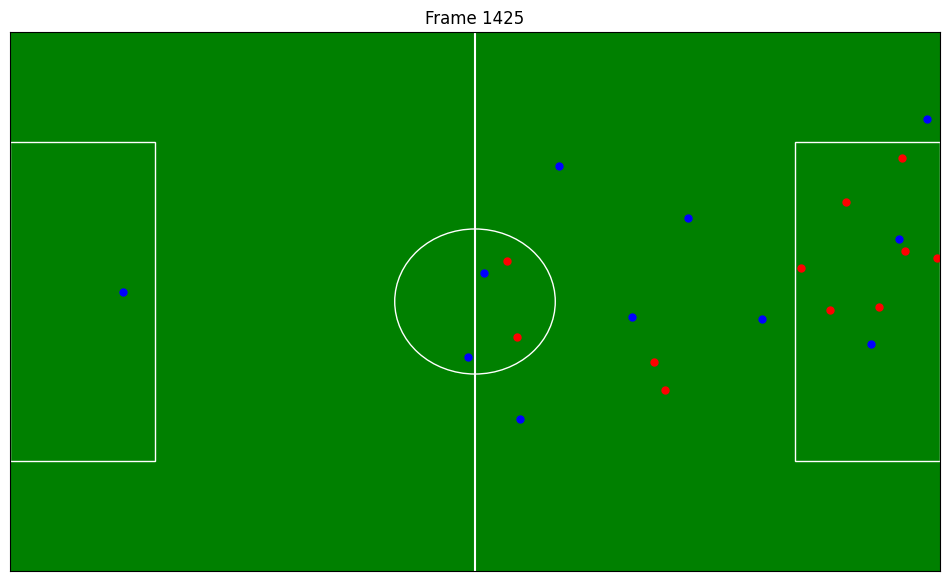

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np

# Use already loaded tracking_home and tracking_away
start_frame = 1015
end_frame = 1425
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]

# === Helper functions ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            player_id = col[:-2]
            x.append(row[f'{player_id}_x'])
            y.append(row[f'{player_id}_y'])
    return np.array(x), np.array(y)

def draw_pitch(ax):
    ax.set_xlim(-53, 53)
    ax.set_ylim(-34, 34)
    ax.set_facecolor('green')
    ax.plot([0, 0], [-34, 34], color='white')
    center_circle = plt.Circle((0, 0), 9.15, color='white', fill=False)
    ax.add_patch(center_circle)
    ax.add_patch(Rectangle((-53, -20.15), 16.5, 40.3, edgecolor='white', fill=False))  # Left box
    ax.add_patch(Rectangle((36.5, -20.15), 16.5, 40.3, edgecolor='white', fill=False))  # Right box
    ax.set_xticks([]), ax.set_yticks([])

# === Set up animation ===
fig, ax = plt.subplots(figsize=(12, 7))
draw_pitch(ax)

home_dots, = ax.plot([], [], 'bo', markersize=5, label='Home')
away_dots, = ax.plot([], [], 'ro', markersize=5, label='Away')
ball_dot,  = ax.plot([], [], 'wo', markersize=5, label='Ball')

def init():
    home_dots.set_data([], [])
    away_dots.set_data([], [])
    ball_dot.set_data([], [])
    return home_dots, away_dots, ball_dot

frame_list = list(range(start_frame, end_frame + 1))

def animate(i):
    frame = frame_list[i]
    
    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)

    bx, by = clip_home.loc[frame]['ball_x'], clip_home.loc[frame]['ball_y']
    
    home_dots.set_data(xh, yh)
    away_dots.set_data(xa, ya)
    ball_dot.set_data([bx], [by])  # ✅ fix: wrap in list
    
    ax.set_title(f"Frame {frame}")
    return home_dots, away_dots, ball_dot


ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frame_list), interval=50, blit=True)

# === Save animation ===
ani.save("decoy_run_animation.mp4", writer="ffmpeg")  # or writer="pillow" and use .gif if ffmpeg isn't available

print("✅ Animation saved as decoy_run_animation.mp4")


✅ Saved: open_play_disruption.mp4


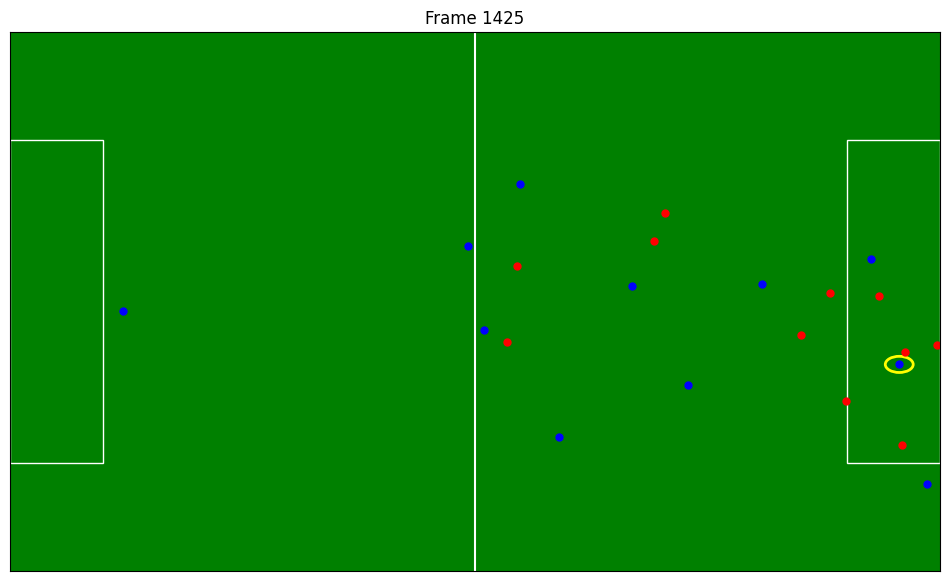

In [26]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle

# === 1. Load Raw Tracking Data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # team name row
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    return df.set_index('Frame')

# === 2. Load Home & Away Tracking Data ===
tracking_home = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "Home")
tracking_away = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "Away")

# === 3. Extract Open Play Sequence ===
start_frame = 1015
end_frame = 1425
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]
frame_list = list(range(start_frame, end_frame + 1))

# === 4. Drawing Helpers ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y)

def draw_pitch(ax):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_facecolor('green')
    ax.plot([0.5, 0.5], [0, 1], color='white')
    ax.add_patch(Rectangle((0.0, 0.2), 0.1, 0.6, edgecolor='white', fill=False))
    ax.add_patch(Rectangle((0.9, 0.2), 0.1, 0.6, edgecolor='white', fill=False))
    ax.set_xticks([]), ax.set_yticks([])

# === 5. Setup Animation ===
fig, ax = plt.subplots(figsize=(12, 7))
draw_pitch(ax)
home_dots, = ax.plot([], [], 'bo', markersize=5)
away_dots, = ax.plot([], [], 'ro', markersize=5)
ball_dot, = ax.plot([], [], 'wo', markersize=6)

# Highlights
striker_circle = Circle((0, 0), 0.015, color='yellow', fill=False, linewidth=2)
#space_circle = Circle((0.75, 0.75), 0.03, color='white', fill=False, linestyle='dashed', linewidth=2)

ax.add_patch(striker_circle)
#ax.add_patch(space_circle)

# === 6. Animate Function ===
def animate(i):
    frame = frame_list[i]

    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)

    # Safe ball access
    if frame in clip_home.index:
        row = clip_home.loc[frame]
        bx, by = row['ball_x'], row['ball_y']
    else:
        bx, by = np.nan, np.nan

    home_dots.set_data(xh, yh)
    away_dots.set_data(xa, ya)
    ball_dot.set_data([bx], [by])

    # Highlight striker (e.g. Home_10 = index 9)
    if len(xh) > 9:
        striker_circle.set_center((xh[9], yh[9]))
    else:
        striker_circle.set_center((0, 0))

    ax.set_title(f"Frame {frame}")
    return home_dots, away_dots, ball_dot, striker_circle

# === 7. Run and Save Animation ===
ani = animation.FuncAnimation(fig, animate, frames=len(frame_list), interval=50, blit=True)
ani.save("open_play_disruption.mp4", writer="ffmpeg")
print("✅ Saved: open_play_disruption.mp4")


✅ Saved as: before_after_disruption.png


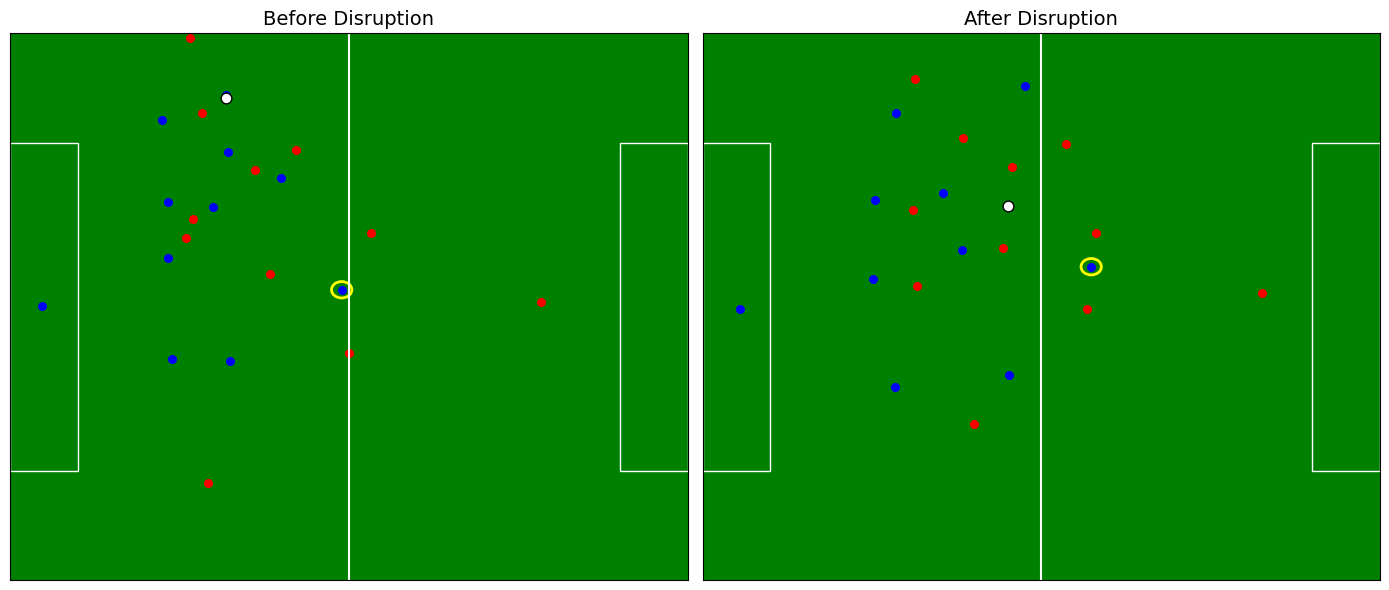

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
import csv

# === 1. Load raw tracking data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    return df.set_index('Frame')

# === 2. Load data ===
home_path = "../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv"
away_path = "../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv"
tracking_home = load_raw_tracking(home_path, "Home")
tracking_away = load_raw_tracking(away_path, "Away")

# === 3. Choose frames ===
frame_before = 1135  # 👈 change this
frame_after = 1224   # 👈 change this

# === 4. Helper to extract player/ball positions ===
def get_positions_at_frame(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y), float(row['ball_x']), float(row['ball_y'])

# === 5. Plotting ===
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
frames = [frame_before, frame_after]
titles = ["Before Disruption", "After Disruption"]

for i, frame in enumerate(frames):
    ax = axs[i]
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_facecolor('green')
    ax.plot([0.5, 0.5], [0, 1], color='white')
    ax.add_patch(Rectangle((0.0, 0.2), 0.1, 0.6, edgecolor='white', fill=False))
    ax.add_patch(Rectangle((0.9, 0.2), 0.1, 0.6, edgecolor='white', fill=False))
    ax.set_xticks([]), ax.set_yticks([])

    xh, yh, bx, by = get_positions_at_frame(tracking_home, frame)
    xa, ya, _, _ = get_positions_at_frame(tracking_away, frame)

    ax.scatter(xh, yh, c='blue', s=30)
    ax.scatter(xa, ya, c='red', s=30)
    ax.scatter([bx], [by], c='white', edgecolors='black', s=60, zorder=5)

    # Highlight striker (e.g. Home_10 = index 9)
    if len(xh) > 9:
        ax.add_patch(Circle((xh[9], yh[9]), 0.015, color='yellow', fill=False, linewidth=2))

    ax.set_title(titles[i], fontsize=14)

plt.tight_layout()
plt.savefig("before_after_disruption.png")
print("✅ Saved as: before_after_disruption.png")


✅ Saved: open_play_disruption_voronoi.mp4


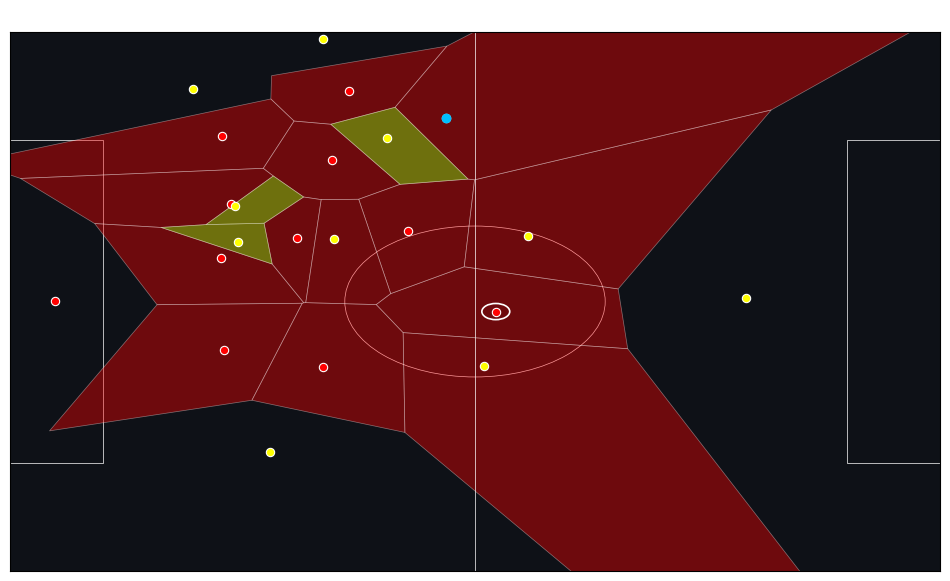

In [17]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle, Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi

# === 1. Load Raw Tracking Data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # skip team name row
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    return df.set_index('Frame')

# === 2. Load Data ===
tracking_home = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "Home")
tracking_away = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "Away")

# === 3. Clip Settings ===
start_frame = 1015
end_frame = 1045
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]
frame_list = list(range(start_frame, end_frame + 1))

# === 4. Position Extractor ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y)

# === 5. Drawing Helpers ===
def draw_dark_pitch(ax):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_facecolor('#0e1117')
    ax.plot([0.5, 0.5], [0, 1], color='white', lw=0.5)
    ax.add_patch(Rectangle((0.0, 0.2), 0.1, 0.6, edgecolor='white', fill=False, lw=0.5))
    ax.add_patch(Rectangle((0.9, 0.2), 0.1, 0.6, edgecolor='white', fill=False, lw=0.5))
    ax.add_patch(plt.Circle((0.5, 0.5), 0.14, edgecolor='white', fill=False, lw=0.5))
    ax.set_xticks([]), ax.set_yticks([])

def draw_voronoi(ax, x_all, y_all, colors):
    points = np.column_stack((x_all, y_all))
    vor = Voronoi(points)
    patches = []
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        if -1 in region or len(region) == 0:
            continue
        polygon = [vor.vertices[i] for i in region if i >= 0]
        patches.append(Polygon(polygon, closed= True))
    collection = PatchCollection(patches, facecolors=colors, edgecolor='white', linewidths=0.5, alpha=0.4)
    ax.add_collection(collection)

# === 6. Setup Animation ===
fig, ax = plt.subplots(figsize=(12, 7))
striker_circle = Circle((0, 0), 0.015, color='white', fill=False, linewidth=1.2)

def animate(i):
    ax.clear()
    draw_dark_pitch(ax)

    frame = frame_list[i]
    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)

    x_all = np.concatenate([xh, xa])
    y_all = np.concatenate([yh, ya])

    # Remove points where either x or y is NaN
    valid = ~(np.isnan(x_all) | np.isnan(y_all))
    x_all = x_all[valid]
    y_all = y_all[valid]
    colors = (['red'] * len(xh) + ['yellow'] * len(xa))
    colors = [c for j, c in enumerate(colors) if valid[j]]

    colors = ['red'] * len(xh) + ['yellow'] * len(xa)

    draw_voronoi(ax, x_all, y_all, colors)
    ax.plot(xh, yh, 'o', color='red', markersize=6, markeredgecolor='white', markeredgewidth=0.8)
    ax.plot(xa, ya, 'o', color='yellow', markersize=6, markeredgecolor='white', markeredgewidth=0.8)

    if frame in clip_home.index:
        row = clip_home.loc[frame]
        bx, by = row['ball_x'], row['ball_y']
        ax.plot([bx], [by], 'o', color='deepskyblue', markersize=6)

    if len(xh) > 9:
        striker_circle.set_center((xh[9], yh[9]))
    else:
        striker_circle.set_center((0, 0))

    ax.add_patch(striker_circle)
    ax.set_title(f"Frame {frame}", color='white')
    return []

# === 7. Render & Save Animation ===
ani = animation.FuncAnimation(fig, animate, frames=len(frame_list), interval=100, blit=True)
ani.save("open_play_disruption_voronoi.mp4", writer="ffmpeg")
print("✅ Saved: open_play_disruption_voronoi.mp4")


✅ Saved: visual4.mp4


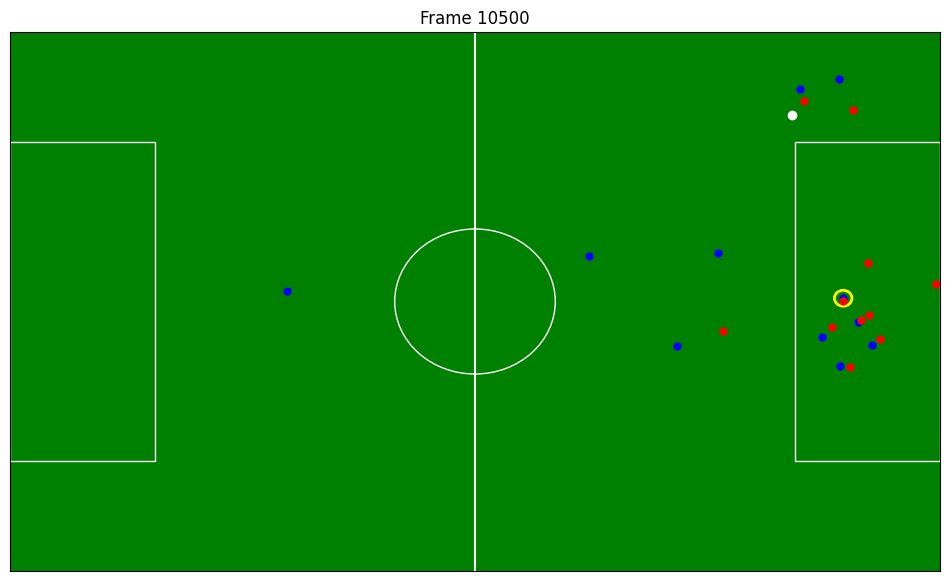

In [116]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle

# === 0. Convert to Metric Coordinates ===
def to_metric_coordinates(df, field_dimen=(106.0, 68.0)):
    x_cols = [c for c in df.columns if '_x' in c and 'ball' not in c]
    y_cols = [c for c in df.columns if '_y' in c and 'ball' not in c]
    df[x_cols] = (df[x_cols] - 0.5) * field_dimen[0]
    df[y_cols] = (0.5 - df[y_cols]) * field_dimen[1]
    df['ball_x'] = (df['ball_x'] - 0.5) * field_dimen[0]
    df['ball_y'] = (0.5 - df['ball_y']) * field_dimen[1]
    return df

# === 1. Load Raw Tracking Data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # team name row
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    df = to_metric_coordinates(df)  # ✅ convert to real field units
    return df.set_index('Frame')

# === 2. Load Home & Away Tracking Data ===
tracking_home = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "Home")
tracking_away = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "Away")

# === 3. Extract Open Play Sequence ===
start_frame = 9000
end_frame = 10500
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]
frame_list = list(range(start_frame, end_frame + 1))

# === 4. Drawing Helpers ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y)

def draw_pitch(ax):
    ax.set_xlim(-53, 53)
    ax.set_ylim(-34, 34)
    ax.set_facecolor('green')
    ax.plot([0, 0], [-34, 34], color='white')  # halfway line
    ax.add_patch(Circle((0, 0), 9.15, edgecolor='white', fill=False))  # center circle
    ax.add_patch(Rectangle((-53, -20.15), 16.5, 40.3, edgecolor='white', fill=False))  # left box
    ax.add_patch(Rectangle((36.5, -20.15), 16.5, 40.3, edgecolor='white', fill=False))  # right box
    ax.set_xticks([]), ax.set_yticks([])

# === 5. Setup Animation ===
fig, ax = plt.subplots(figsize=(12, 7))
draw_pitch(ax)
home_dots, = ax.plot([], [], 'bo', markersize=5)
away_dots, = ax.plot([], [], 'ro', markersize=5)
ball_dot, = ax.plot([], [], 'wo', markersize=6)

# Highlight circle for a specific player (e.g., striker)
striker_circle = Circle((0, 0), 1.0, color='yellow', fill=False, linewidth=2)
ax.add_patch(striker_circle)

# === 6. Animate Function ===
def animate(i):
    frame = frame_list[i]

    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)

    if frame in clip_home.index:
        row = clip_home.loc[frame]
        bx, by = row['ball_x'], row['ball_y']
    else:
        bx, by = np.nan, np.nan

    home_dots.set_data(xh, yh)
    away_dots.set_data(xa, ya)
    ball_dot.set_data([bx], [by])

    if len(xh) > 9:
        striker_circle.set_center((xh[9], yh[9]))
    else:
        striker_circle.set_center((0, 0))

    ax.set_title(f"Frame {frame}")
    return home_dots, away_dots, ball_dot, striker_circle

# === 7. Run and Save Animation ===
ani = animation.FuncAnimation(fig, animate, frames=len(frame_list), interval=50, blit=True)
ani.save("visual1_tested.mp4", writer="ffmpeg")
print("✅ Saved: visual4.mp4")


Script with Defensive Line Overlay



✅ Saved: visual5.gif (PowerPoint-ready)


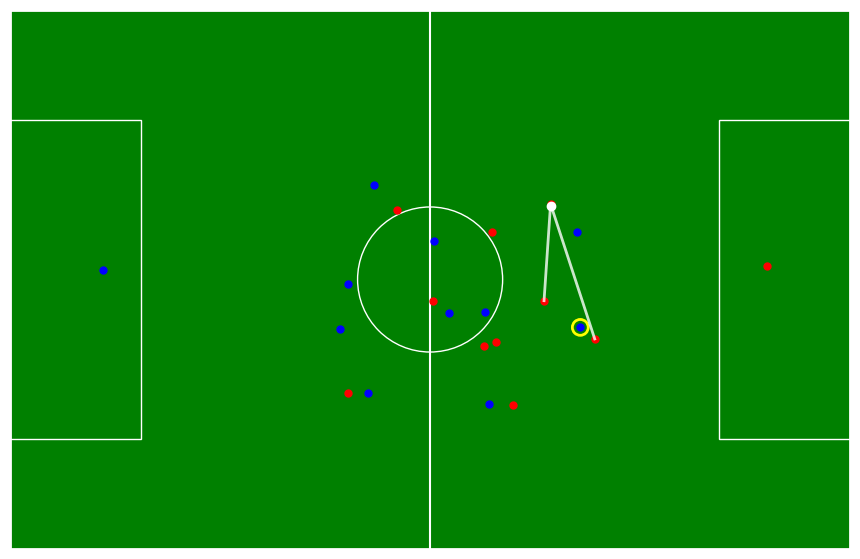

In [115]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Rectangle, Circle

# === 0. Convert to Metric Coordinates ===
def to_metric_coordinates(df, field_dimen=(106.0, 68.0)):
    x_cols = [c for c in df.columns if '_x' in c and 'ball' not in c]
    y_cols = [c for c in df.columns if '_y' in c and 'ball' not in c]
    df[x_cols] = (df[x_cols] - 0.5) * field_dimen[0]
    df[y_cols] = (0.5 - df[y_cols]) * field_dimen[1]
    df['ball_x'] = (df['ball_x'] - 0.5) * field_dimen[0]
    df['ball_y'] = (0.5 - df['ball_y']) * field_dimen[1]
    return df

# === 1. Load Raw Tracking Data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    df = to_metric_coordinates(df)
    return df.set_index('Frame')

# === 2. Load Home & Away Tracking Data ===
tracking_home = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "Home")
tracking_away = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "Away")

# === 3. Extract Open Play Sequence ===
start_frame = 500
end_frame = 650
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]
frame_list = list(range(start_frame, end_frame + 1))

# === 4. Drawing Helpers ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y)

def draw_pitch(ax):
    ax.set_xlim(-53, 53)
    ax.set_ylim(-34, 34)
    ax.set_facecolor('green')
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

    # Remove axis borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Pitch markings
    ax.plot([0, 0], [-34, 34], color='white')  # Halfway line
    ax.add_patch(Circle((0, 0), 9.15, edgecolor='white', fill=False))  # Center circle
    ax.add_patch(Rectangle((-53, -20.15), 16.5, 40.3, edgecolor='white', fill=False))  # Left box
    ax.add_patch(Rectangle((36.5, -20.15), 16.5, 40.3, edgecolor='white', fill=False))  # Right box

    # ✅ Add outer pitch border
    ax.add_patch(Rectangle((-53, -34), 106, 68, edgecolor='white', facecolor='none', linewidth=2))



# === 5. Define Defensive Line Players ===
defensive_line_away = ['Away_15', 'Away_16', 'Away_17']  # Adjust as needed

def draw_player_line(ax, frame_row, player_ids, color='white'):
    points = []
    for pid in player_ids:
        x_col = f"{pid}_x"
        y_col = f"{pid}_y"
        if x_col in frame_row and y_col in frame_row:
            x = frame_row[x_col]
            y = frame_row[y_col]
            if not np.isnan(x) and not np.isnan(y):
                points.append((x, y))
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        ax.plot([x1, x2], [y1, y2], color=color, lw=1.5, alpha=0.7)

# === 6. Setup Animation ===
fig, ax = plt.subplots(figsize=(12, 7))
draw_pitch(ax)
home_dots, = ax.plot([], [], 'bo', markersize=5)
away_dots, = ax.plot([], [], 'ro', markersize=5)
ball_dot, = ax.plot([], [], 'wo', markersize=6)

striker_circle = Circle((0, 0), 1.0, color='yellow', fill=False, linewidth=2)
ax.add_patch(striker_circle)

# === 7. Animate Function ===
def animate(i):
    frame = frame_list[i]
    ax.clear()
    draw_pitch(ax)

    # Plot players and ball
    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)

    if frame in clip_home.index:
        row_home = clip_home.loc[frame]
        bx, by = row_home['ball_x'], row_home['ball_y']
    else:
        bx, by = np.nan, np.nan

    ax.plot(xh, yh, 'bo', markersize=5)
    ax.plot(xa, ya, 'ro', markersize=5)
    ax.plot([bx], [by], 'wo', markersize=6)

    # 🟡 Striker highlight
    if len(xh) > 9:
        striker_circle.set_center((xh[9], yh[9]))
    else:
        striker_circle.set_center((0, 0))
    ax.add_patch(striker_circle)

    # ⚪️ Defensive line for Away
    if frame in clip_away.index:
        row_away = clip_away.loc[frame]
        points = []
        for pid in defensive_line_away:
            x_key = f"{pid}_x"
            y_key = f"{pid}_y"
            if x_key in row_away and y_key in row_away:
                x = row_away[x_key]
                y = row_away[y_key]
                if not np.isnan(x) and not np.isnan(y):
                    points.append((x, y))
        if len(points) >= 2:
            xs, ys = zip(*points)
            ax.plot(xs, ys, color='white', linewidth=2, alpha=0.8)

    # ax.set_title(f"Frame {frame}")
    return []



# === 8. Run and Save Animation ===
ani = animation.FuncAnimation(fig, animate, frames=len(frame_list), interval=50, blit=True)
ani.save(
    "visual6_updated2.gif",
    writer=PillowWriter(fps=20),
    dpi=150,
    savefig_kwargs={
        "bbox_inches": "tight",
        "pad_inches": 0,
        "facecolor": "green"  # ensures background stays green
    }
)

print("✅ Saved: visual5.gif (PowerPoint-ready)")


In [31]:
print("🔎 Available Away player columns:")
print([col for col in tracking_away.columns if col.startswith('Away_') and col.endswith('_x')])


🔎 Available Away player columns:
['Away_25_x', 'Away_15_x', 'Away_16_x', 'Away_17_x', 'Away_18_x', 'Away_19_x', 'Away_20_x', 'Away_21_x', 'Away_22_x', 'Away_23_x', 'Away_24_x', 'Away_26_x', 'Away_27_x', 'Away_28_x']


✅ Saved: test_visual.mp4


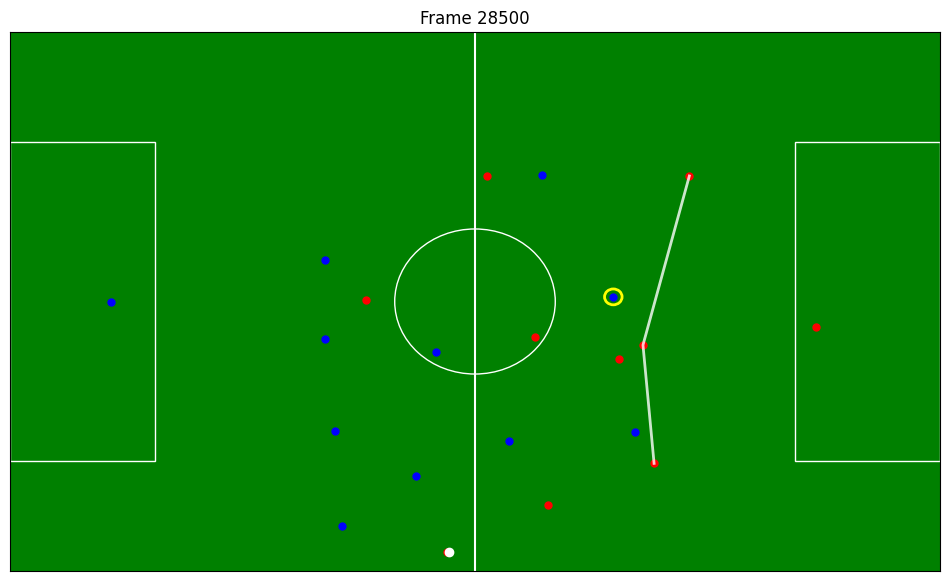

In [119]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle

# === 0. Convert to Metric Coordinates ===
def to_metric_coordinates(df, field_dimen=(106.0, 68.0)):
    x_cols = [c for c in df.columns if '_x' in c and 'ball' not in c]
    y_cols = [c for c in df.columns if '_y' in c and 'ball' not in c]
    df[x_cols] = (df[x_cols] - 0.5) * field_dimen[0]
    df[y_cols] = (0.5 - df[y_cols]) * field_dimen[1]
    df['ball_x'] = (df['ball_x'] - 0.5) * field_dimen[0]
    df['ball_y'] = (0.5 - df['ball_y']) * field_dimen[1]
    return df

# === 1. Load Raw Tracking Data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    df = to_metric_coordinates(df)
    return df.set_index('Frame')

# === 2. Load Home & Away Tracking Data ===
tracking_home = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "Home")
tracking_away = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "Away")

# === 3. Extract Open Play Sequence ===
start_frame = 27850
end_frame = 28500
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]
frame_list = list(range(start_frame, end_frame + 1))

# === 4. Drawing Helpers ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y)

def draw_pitch(ax):
    ax.set_xlim(-53, 53)
    ax.set_ylim(-34, 34)
    ax.set_facecolor('green')
    ax.plot([0, 0], [-34, 34], color='white')
    ax.add_patch(Circle((0, 0), 9.15, edgecolor='white', fill=False))
    ax.add_patch(Rectangle((-53, -20.15), 16.5, 40.3, edgecolor='white', fill=False))
    ax.add_patch(Rectangle((36.5, -20.15), 16.5, 40.3, edgecolor='white', fill=False))
    ax.set_xticks([]), ax.set_yticks([])

# === 5. Define Defensive Line Players ===
defensive_line_away = ['Away_15', 'Away_16', 'Away_17']  # Adjust as needed

def draw_player_line(ax, frame_row, player_ids, color='white'):
    points = []
    for pid in player_ids:
        x_col = f"{pid}_x"
        y_col = f"{pid}_y"
        if x_col in frame_row and y_col in frame_row:
            x = frame_row[x_col]
            y = frame_row[y_col]
            if not np.isnan(x) and not np.isnan(y):
                points.append((x, y))
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        ax.plot([x1, x2], [y1, y2], color=color, lw=1.5, alpha=0.7)

# === 6. Setup Animation ===
fig, ax = plt.subplots(figsize=(12, 7))
draw_pitch(ax)
home_dots, = ax.plot([], [], 'bo', markersize=5)
away_dots, = ax.plot([], [], 'ro', markersize=5)
ball_dot, = ax.plot([], [], 'wo', markersize=6)

striker_circle = Circle((0, 0), 1.0, color='yellow', fill=False, linewidth=2)
ax.add_patch(striker_circle)

# === 7. Animate Function ===
def animate(i):
    frame = frame_list[i]
    ax.clear()
    draw_pitch(ax)

    # Plot players and ball
    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)

    if frame in clip_home.index:
        row_home = clip_home.loc[frame]
        bx, by = row_home['ball_x'], row_home['ball_y']
    else:
        bx, by = np.nan, np.nan

    ax.plot(xh, yh, 'bo', markersize=5)
    ax.plot(xa, ya, 'ro', markersize=5)
    ax.plot([bx], [by], 'wo', markersize=6)

    # 🟡 Striker highlight
    if len(xh) > 9:
        striker_circle.set_center((xh[9], yh[9]))
    else:
        striker_circle.set_center((0, 0))
    ax.add_patch(striker_circle)

    # ⚪️ Defensive line for Away
    if frame in clip_away.index:
        row_away = clip_away.loc[frame]
        points = []
        for pid in defensive_line_away:
            x_key = f"{pid}_x"
            y_key = f"{pid}_y"
            if x_key in row_away and y_key in row_away:
                x = row_away[x_key]
                y = row_away[y_key]
                if not np.isnan(x) and not np.isnan(y):
                    points.append((x, y))
        if len(points) >= 2:
            xs, ys = zip(*points)
            ax.plot(xs, ys, color='white', linewidth=2, alpha=0.8)

    ax.set_title(f"Frame {frame}")
    return []



# === 8. Run and Save Animation ===
ani = animation.FuncAnimation(fig, animate, frames=len(frame_list), interval=50, blit=True)
ani.save("test_visual11111.mp4", writer="ffmpeg")
print("✅ Saved: test_visual.mp4")


✅ Saved: width_test.gif (PowerPoint-ready)


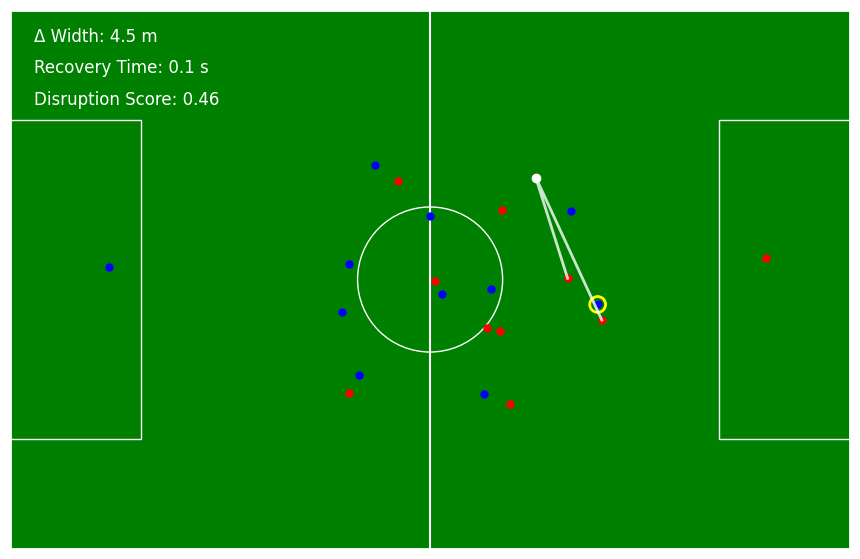

In [67]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Rectangle, Circle

# === 0. Convert to Metric Coordinates ===
def to_metric_coordinates(df, field_dimen=(106.0, 68.0)):
    x_cols = [c for c in df.columns if '_x' in c and 'ball' not in c]
    y_cols = [c for c in df.columns if '_y' in c and 'ball' not in c]
    df[x_cols] = (df[x_cols] - 0.5) * field_dimen[0]
    df[y_cols] = (0.5 - df[y_cols]) * field_dimen[1]
    df['ball_x'] = (df['ball_x'] - 0.5) * field_dimen[0]
    df['ball_y'] = (0.5 - df['ball_y']) * field_dimen[1]
    return df

# === 1. Load Raw Tracking Data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    df = to_metric_coordinates(df)
    return df.set_index('Frame')

# === 2. Load Home & Away Tracking Data ===
tracking_home = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "Home")
tracking_away = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "Away")

# === 3. Extract Open Play Sequence ===
start_frame = 500
end_frame = 670
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]
frame_list = list(range(start_frame, end_frame + 1))

# === 4. Drawing Helpers ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y)

def draw_pitch(ax):
    ax.set_xlim(-53, 53)
    ax.set_ylim(-34, 34)
    ax.set_facecolor('green')
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

    # Remove axis borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Pitch markings
    ax.plot([0, 0], [-34, 34], color='white')  # Halfway line
    ax.add_patch(Circle((0, 0), 9.15, edgecolor='white', fill=False))  # Center circle
    ax.add_patch(Rectangle((-53, -20.15), 16.5, 40.3, edgecolor='white', fill=False))  # Left box
    ax.add_patch(Rectangle((36.5, -20.15), 16.5, 40.3, edgecolor='white', fill=False))  # Right box

    # ✅ Add outer pitch border
    ax.add_patch(Rectangle((-53, -34), 106, 68, edgecolor='white', facecolor='none', linewidth=2))



# === 5. Define Defensive Line Players ===
defensive_line_away = ['Away_15', 'Away_16', 'Away_17']  # Adjust as needed

def draw_player_line(ax, frame_row, player_ids, color='white'):
    points = []
    for pid in player_ids:
        x_col = f"{pid}_x"
        y_col = f"{pid}_y"
        if x_col in frame_row and y_col in frame_row:
            x = frame_row[x_col]
            y = frame_row[y_col]
            if not np.isnan(x) and not np.isnan(y):
                points.append((x, y))
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        ax.plot([x1, x2], [y1, y2], color=color, lw=1.5, alpha=0.7)

# === 6. Setup Animation ===
fig, ax = plt.subplots(figsize=(12, 7))
draw_pitch(ax)
home_dots, = ax.plot([], [], 'bo', markersize=5)
away_dots, = ax.plot([], [], 'ro', markersize=5)
ball_dot, = ax.plot([], [], 'wo', markersize=6)

striker_circle = Circle((0, 0), 1.0, color='yellow', fill=False, linewidth=2)
ax.add_patch(striker_circle)

# === 6.5 Compute Disruption Metrics ===

def defensive_line_width(frame_row, player_ids):
    xs = []
    for pid in player_ids:
        x_col = f"{pid}_x"
        if x_col in frame_row:
            x = frame_row[x_col]
            if not np.isnan(x):
                xs.append(x)
    return max(xs) - min(xs) if xs else 0.0

def find_recovery_time(clip, player_ids, original_width, start_frame, end_frame, threshold=2.0, stable_frames=5):
    consecutive = 0
    for f in range(start_frame + 1, end_frame + 1):
        if f not in clip.index:
            continue
        width_now = defensive_line_width(clip.loc[f], player_ids)
        if abs(width_now - original_width) < threshold:
            consecutive += 1
            if consecutive >= stable_frames:
                return (f - start_frame - stable_frames + 1) / 10  # offset for start of recovery window
        else:
            consecutive = 0  # reset if broken
    return None




# Compute disruption metrics
width_before = defensive_line_width(clip_away.loc[500], defensive_line_away)
width_peak = max(defensive_line_width(clip_away.loc[f], defensive_line_away) for f in range(501, 540))
delta_width = width_peak - width_before
recovery_time = find_recovery_time(
    clip=clip_away,
    player_ids=defensive_line_away,
    original_width=width_before,
    start_frame=start_frame,
    end_frame=end_frame,
    threshold=2.0,           # Keep as is
    stable_frames=10         # 👈 Try increasing to 10 or even 15
)


disruption_score = min(1.0, (delta_width / 10) + ((recovery_time or 0) / 10))


# === 7. Animate Function ===
def animate(i):
    frame = frame_list[i]
    ax.clear()
    draw_pitch(ax)

    # Plot players and ball
    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)

    if frame in clip_home.index:
        row_home = clip_home.loc[frame]
        bx, by = row_home['ball_x'], row_home['ball_y']
    else:
        bx, by = np.nan, np.nan

    ax.plot(xh, yh, 'bo', markersize=5)
    ax.plot(xa, ya, 'ro', markersize=5)
    ax.plot([bx], [by], 'wo', markersize=6)

    # 🟡 Striker highlight
    if len(xh) > 9:
        striker_circle.set_center((xh[9], yh[9]))
    else:
        striker_circle.set_center((0, 0))
    ax.add_patch(striker_circle)

    # ⚪️ Defensive line for Away
    if frame in clip_away.index:
        row_away = clip_away.loc[frame]
        points = []
        for pid in defensive_line_away:
            x_key = f"{pid}_x"
            y_key = f"{pid}_y"
            if x_key in row_away and y_key in row_away:
                x = row_away[x_key]
                y = row_away[y_key]
                if not np.isnan(x) and not np.isnan(y):
                    points.append((x, y))
        if len(points) >= 2:
            xs, ys = zip(*points)
            ax.plot(xs, ys, color='white', linewidth=2, alpha=0.8)
    
    # Overlay disruption metrics in top-left
    ax.text(-50, 30, f"Δ Width: {delta_width:.1f} m", color='white', fontsize=12)
    ax.text(-50, 26, f"Recovery Time: {recovery_time:.1f} s" if recovery_time is not None else "Recovery Time: —", color='white', fontsize=12)
    ax.text(-50, 22, f"Disruption Score: {disruption_score:.2f}", color='white', fontsize=12)



    # ax.set_title(f"Frame {frame}")
    return []



# === 8. Run and Save Animation ===
ani = animation.FuncAnimation(fig, animate, frames=len(frame_list), interval=50, blit=True)
ani.save(
    "visual5_test.gif",
    writer=PillowWriter(fps=20),
    dpi=150,
    savefig_kwargs={
        "bbox_inches": "tight",
        "pad_inches": 0,
        "facecolor": "green"  # ensures background stays green
    }
)

print("✅ Saved: width_test.gif (PowerPoint-ready)")

✅ Saved: visual6_updated.gif (PowerPoint-ready)


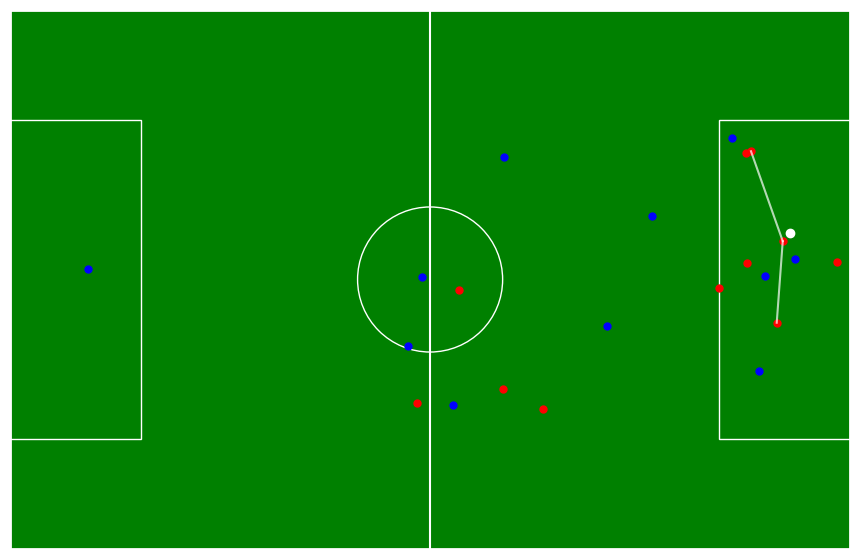

In [ ]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Rectangle, Circle

# === 0. Convert to Metric Coordinates ===
def to_metric_coordinates(df, field_dimen=(106.0, 68.0)):
    x_cols = [c for c in df.columns if '_x' in c and 'ball' not in c]
    y_cols = [c for c in df.columns if '_y' in c and 'ball' not in c]
    df[x_cols] = (df[x_cols] - 0.5) * field_dimen[0]
    df[y_cols] = (0.5 - df[y_cols]) * field_dimen[1]
    df['ball_x'] = (df['ball_x'] - 0.5) * field_dimen[0]
    df['ball_y'] = (0.5 - df['ball_y']) * field_dimen[1]
    return df

# === 1. Load Raw Tracking Data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    df = to_metric_coordinates(df)
    return df.set_index('Frame')

# === 2. Load Tracking Data ===
tracking_home = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "Home")
tracking_away = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "Away")

# === 3. Define Clip Range ===
start_frame = 27850
end_frame = 28520
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]
frame_list = list(range(start_frame, end_frame + 1))

# === 4. Player Coordinates Extraction ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y)

# === 5. Draw Soccer Pitch ===
def draw_pitch(ax):
    ax.set_xlim(-53, 53)
    ax.set_ylim(-34, 34)
    ax.set_facecolor('green')
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.plot([0, 0], [-34, 34], color='white')
    ax.add_patch(Circle((0, 0), 9.15, edgecolor='white', fill=False))
    ax.add_patch(Rectangle((-53, -20.15), 16.5, 40.3, edgecolor='white', fill=False))
    ax.add_patch(Rectangle((36.5, -20.15), 16.5, 40.3, edgecolor='white', fill=False))
    ax.add_patch(Rectangle((-53, -34), 106, 68, edgecolor='white', facecolor='none', linewidth=2))

# === 6. Defensive Line ===
defensive_line_away = ['Away_15', 'Away_16', 'Away_17']

def draw_player_line(ax, frame_row, player_ids, color='white'):
    points = []
    for pid in player_ids:
        x_col = f"{pid}_x"
        y_col = f"{pid}_y"
        if x_col in frame_row and y_col in frame_row:
            x, y = frame_row[x_col], frame_row[y_col]
            if not np.isnan(x) and not np.isnan(y):
                points.append((x, y))
    for i in range(len(points) - 1):
        ax.plot([points[i][0], points[i+1][0]], [points[i][1], points[i+1][1]], color=color, lw=1.5, alpha=0.7)

# === 7. Disruption Metrics ===
def defensive_line_width(row, player_ids):
    ys = [row.get(f"{pid}_y", np.nan) for pid in player_ids]
    ys = [y for y in ys if not np.isnan(y)]
    return max(ys) - min(ys) if ys else 0.0


def defensive_line_dispersion(row, player_ids):
    points = []
    for pid in player_ids:
        x = row.get(f"{pid}_x", np.nan)
        y = row.get(f"{pid}_y", np.nan)
        if not np.isnan(x) and not np.isnan(y):
            points.append((x, y))
    if len(points) < 2:
        return 0.0
    return max(np.linalg.norm(np.array(p1) - np.array(p2)) for i, p1 in enumerate(points) for p2 in points[i+1:])

def find_recovery_time(clip, player_ids, original_width, start_frame, end_frame, threshold=2.0, stable_frames=10, delay=5):
    consecutive = 0
    for f in range(start_frame + delay, end_frame + 1):
        if f not in clip.index:
            continue
        width_now = defensive_line_width(clip.loc[f], player_ids)
        if abs(width_now - original_width) < threshold:
            consecutive += 1
            if consecutive >= stable_frames:
                return (f - start_frame - stable_frames + 1) / 10
        else:
            consecutive = 0
    return None

# === 8. Compute Metrics ===
width_before = defensive_line_width(clip_away.loc[start_frame], defensive_line_away)
width_peak = max(defensive_line_width(clip_away.loc[f], defensive_line_away) for f in range(start_frame + 1, start_frame + 40))
delta_width = width_peak - width_before

dispersion_before = defensive_line_dispersion(clip_away.loc[start_frame], defensive_line_away)
dispersion_peak = max(defensive_line_dispersion(clip_away.loc[f], defensive_line_away) for f in range(start_frame + 1, start_frame + 40))
delta_dispersion = dispersion_peak - dispersion_before

recovery_time = find_recovery_time(clip_away, defensive_line_away, width_before, start_frame, end_frame)

# Composite disruption score
disruption_score = min(1.0, (delta_width / 10) + (delta_dispersion / 10) + ((recovery_time or 0) / 10))

# === 9. Animation Setup ===
fig, ax = plt.subplots(figsize=(12, 7))
draw_pitch(ax)
home_dots, = ax.plot([], [], 'bo', markersize=5)
away_dots, = ax.plot([], [], 'ro', markersize=5)
ball_dot, = ax.plot([], [], 'wo', markersize=6)
#striker_circle = Circle((0, 0), 1.0, color='yellow', fill=False, linewidth=2)
#ax.add_patch(striker_circle)

# === 10. Animate ===
def animate(i):
    frame = frame_list[i]
    ax.clear()
    draw_pitch(ax)

    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)
    bx, by = clip_home.loc[frame][['ball_x', 'ball_y']] if frame in clip_home.index else (np.nan, np.nan)

    ax.plot(xh, yh, 'bo', markersize=5)
    ax.plot(xa, ya, 'ro', markersize=5)
    ax.plot([bx], [by], 'wo', markersize=6)

    if len(xh) > 9:
        striker_circle.set_center((xh[9], yh[9]))
    else:
        striker_circle.set_center((0, 0))
    #ax.add_patch(striker_circle)

    # Draw defensive line
    if frame in clip_away.index:
        draw_player_line(ax, clip_away.loc[frame], defensive_line_away)

    # Metrics
    # ax.text(-50, 32, f"Δ Width: {delta_width:.1f} m", color='white', fontsize=12)
    # ax.text(-50, 28, f"Δ Dispersion: {delta_dispersion:.1f} m", color='white', fontsize=12)
    # ax.text(-50, 24, f"Recovery Time: {recovery_time:.1f} s" if recovery_time else "Recovery Time: —", color='white', fontsize=12)
    # ax.text(-50, 20, f"Disruption Score: {disruption_score:.2f}", color='white', fontsize=12)


    return []

# === 11. Save Animation ===
ani = animation.FuncAnimation(fig, animate, frames=len(frame_list), interval=50, blit=True)
ani.save("visual3_calculation.gif", writer=PillowWriter(fps=20), dpi=150, savefig_kwargs={
    "bbox_inches": "tight", "pad_inches": 0, "facecolor": "green"
})
print("✅ Saved: visual6_updated.gif (PowerPoint-ready)")


In [54]:
min_frame = tracking_away.index.min()
max_frame = tracking_away.index.max()
print(f"Min frame: {min_frame}, Max frame: {max_frame}")


Min frame: 1, Max frame: 145006


In [109]:
disruption_scores = []

for t in range(500, 620, 10):  # Frame window
    try:
        row_before = tracking_away.loc[t]
        width_before = defensive_line_width(row_before, defensive_line_away)

        # Peak width in next 40 frames
        width_peak = max(defensive_line_width(tracking_away.loc[f], defensive_line_away)
                         for f in range(t+1, min(t+40, tracking_away.index[-1])))

        delta_width = width_peak - width_before

        # Check if it recovers in next 100 frames
        recovery_time = find_recovery_time(tracking_away, defensive_line_away, width_before,
                                           t, min(t+100, tracking_away.index[-1]))

        disruption_score = min(1.0, (delta_width / 10) + ((recovery_time or 0) / 10))

        disruption_scores.append({
            'start_frame': t,
            'delta_width': round(delta_width, 2),
            'recovery_time': round(recovery_time, 2) if recovery_time else None,
            'disruption_score': round(disruption_score, 2)
        })

    except Exception:
        continue

df = pd.DataFrame(disruption_scores)
print(df.columns)
print(df.head())
print("\n🟢 Top 5 Disruptive Moments")
print(df.sort_values(by="disruption_score", ascending=False).head(5))

print("\n🔵 Least Disruptive Moments")
print(df.sort_values(by="disruption_score", ascending=True).head(5))


Index(['start_frame', 'delta_width', 'recovery_time', 'disruption_score'], dtype='object')
   start_frame  delta_width  recovery_time  disruption_score
0          500        -0.15            NaN             -0.01
1          510        -0.17            NaN             -0.02
2          520        -0.18            9.1              0.89
3          530        -0.23            5.5              0.53
4          540         0.05            0.5              0.06

🟢 Top 5 Disruptive Moments
   start_frame  delta_width  recovery_time  disruption_score
2          520        -0.18            9.1              0.89
3          530        -0.23            5.5              0.53
7          570         3.40            0.5              0.39
6          560         3.25            0.5              0.38
8          580         3.20            0.5              0.37

🔵 Least Disruptive Moments
    start_frame  delta_width  recovery_time  disruption_score
1           510        -0.17            NaN             -0.

In [114]:
disruption_scores = []

for t in range(500,620,10):  # Frame window
    try:
        row_before = tracking_away.loc[t]
        width_before = defensive_line_width(row_before, defensive_line_away)
        dispersion_before = defensive_line_dispersion(row_before, defensive_line_away)

        # Peak width & dispersion in next 40 frames
        width_peak = max(defensive_line_width(tracking_away.loc[f], defensive_line_away)
                         for f in range(t + 1, min(t + 40, tracking_away.index[-1])))

        dispersion_peak = max(defensive_line_dispersion(tracking_away.loc[f], defensive_line_away)
                              for f in range(t + 1, min(t + 40, tracking_away.index[-1])))

        delta_width = width_peak - width_before
        delta_dispersion = dispersion_peak - dispersion_before

        # Recovery time in next 100 frames
        recovery_time = find_recovery_time(
            tracking_away, defensive_line_away, width_before,
            t, min(t + 100, tracking_away.index[-1]),
            threshold=2.0, stable_frames=10, delay=5
        )

        # Composite disruption score
        disruption_score = min(1.0, (delta_width / 10) + (delta_dispersion / 10) + ((recovery_time or 0) / 10))

        disruption_scores.append({
            'start_frame': t,
            'delta_width': round(delta_width, 2),
            'delta_dispersion': round(delta_dispersion, 2),
            'recovery_time': round(recovery_time, 2) if recovery_time else None,
            'disruption_score': round(disruption_score, 2)
        })

    except Exception:
        continue

df = pd.DataFrame(disruption_scores)
print(df.columns)
print(df.head())

print("\n🟢 Top 5 Disruptive Moments")
print(df.sort_values(by="disruption_score", ascending=False).head(5))

print("\n🔵 Least Disruptive Moments")
print(df.sort_values(by="disruption_score", ascending=True).head(5))


Index(['start_frame', 'delta_width', 'delta_dispersion', 'recovery_time',
       'disruption_score'],
      dtype='object')
   start_frame  delta_width  delta_dispersion  recovery_time  disruption_score
0          500        -0.15             -0.15            NaN             -0.03
1          510        -0.17             -0.17            NaN             -0.03
2          520        -0.18             -0.18            9.1              0.87
3          530        -0.23             -0.21            5.5              0.51
4          540         0.05             -0.22            0.5              0.03

🟢 Top 5 Disruptive Moments
   start_frame  delta_width  delta_dispersion  recovery_time  disruption_score
2          520        -0.18             -0.18            9.1              0.87
7          570         3.40              3.11            0.5              0.70
8          580         3.20              3.05            0.5              0.68
6          560         3.25              2.89            0

In [128]:
pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


voronoi

✅ Saved: visual6_updated.gif (PowerPoint-ready)


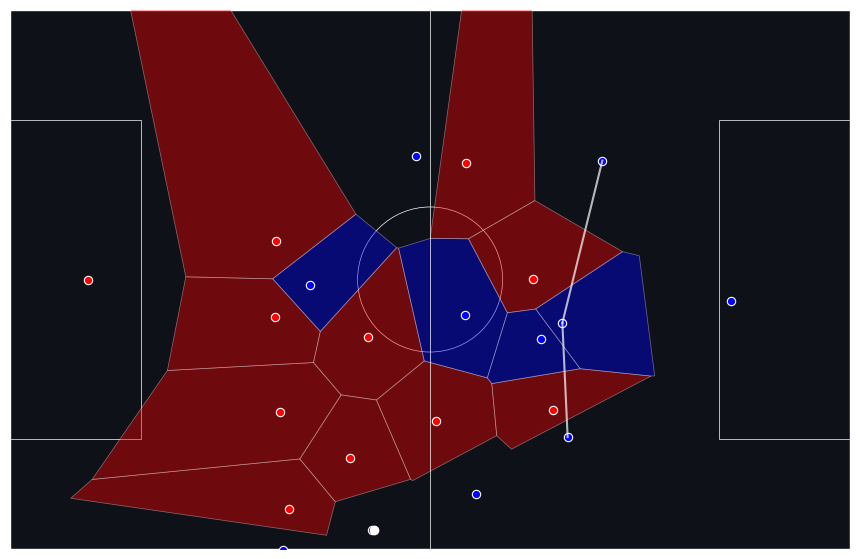

In [132]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Rectangle, Circle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi
from shapely.geometry import Polygon as ShapelyPolygon, box
from shapely.ops import unary_union


# === 0. Convert to Metric Coordinates ===
def to_metric_coordinates(df, field_dimen=(106.0, 68.0)):
    x_cols = [c for c in df.columns if '_x' in c and 'ball' not in c]
    y_cols = [c for c in df.columns if '_y' in c and 'ball' not in c]
    df[x_cols] = (df[x_cols] - 0.5) * field_dimen[0]
    df[y_cols] = (0.5 - df[y_cols]) * field_dimen[1]
    df['ball_x'] = (df['ball_x'] - 0.5) * field_dimen[0]
    df['ball_y'] = (0.5 - df['ball_y']) * field_dimen[1]
    return df

# === 1. Load Raw Tracking Data ===
def load_raw_tracking(file_path, team_name):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        jerseys = [x for x in next(reader) if x != '']
        columns = next(reader)
        for i, j in enumerate(jerseys):
            columns[i*2+3] = f"{team_name}_{j}_x"
            columns[i*2+4] = f"{team_name}_{j}_y"
        columns[-2] = "ball_x"
        columns[-1] = "ball_y"
    df = pd.read_csv(file_path, skiprows=3, names=columns)
    df = df[df['Frame'] != 'Frame'].copy()
    df['Frame'] = df['Frame'].astype(int)
    df['Time [s]'] = df['Time [s]'].astype(float)
    df['ball_x'] = pd.to_numeric(df['ball_x'], errors='coerce')
    df['ball_y'] = pd.to_numeric(df['ball_y'], errors='coerce')
    df = to_metric_coordinates(df)
    return df.set_index('Frame')

# === 2. Load Tracking Data ===
tracking_home = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", "Home")
tracking_away = load_raw_tracking("../data/metrica-tracking-data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", "Away")

# === 3. Define Clip Range ===
start_frame = 27850
end_frame = 28520
clip_home = tracking_home.loc[start_frame:end_frame]
clip_away = tracking_away.loc[start_frame:end_frame]
frame_list = list(range(start_frame, end_frame + 1))

# === 4. Player Coordinates Extraction ===
def get_positions(df, frame):
    row = df.loc[frame]
    x, y = [], []
    for col in df.columns:
        if '_x' in col and 'ball' not in col:
            x.append(float(row[col]))
        elif '_y' in col and 'ball' not in col:
            y.append(float(row[col]))
    return np.array(x), np.array(y)

# === 5. Draw Soccer Pitch ===
def draw_dark_pitch(ax):
    ax.set_xlim(-53, 53)
    ax.set_ylim(-34, 34)
    ax.set_facecolor('#0e1117')
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.plot([0, 0], [-34, 34], color='white', lw=0.5)
    ax.add_patch(Rectangle((-53, -20.15), 16.5, 40.3, edgecolor='white', fill=False, lw=0.5))
    ax.add_patch(Rectangle((36.5, -20.15), 16.5, 40.3, edgecolor='white', fill=False, lw=0.5))
    ax.add_patch(Circle((0, 0), 9.15, edgecolor='white', fill=False, lw=0.5))
    ax.add_patch(Rectangle((-53, -34), 106, 68, edgecolor='white', facecolor='none', linewidth=1))

# === Add Voronoi Drawing ===
def draw_voronoi(ax, x_all, y_all, colors):
    points = np.column_stack((x_all, y_all))
    vor = Voronoi(points)

    # Define pitch bounds as a shapely box
    pitch_bounds = box(-53, -34, 53, 34)

    patches = []
    valid_colors = []

    for point_idx, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 in region or len(region) == 0:
            continue
        polygon = [vor.vertices[i] for i in region if i >= 0]
        cell = ShapelyPolygon(polygon)

        # Clip cell to pitch bounds
        clipped = cell.intersection(pitch_bounds)

        if not clipped.is_empty and clipped.geom_type == 'Polygon':
            patches.append(Polygon(list(clipped.exterior.coords), closed=True))
            valid_colors.append(colors[point_idx])  # match the color of the point

    # Add clipped cells
    collection = PatchCollection(patches, facecolors=valid_colors, edgecolor='white', linewidths=0.5, alpha=0.4)
    ax.add_collection(collection)



# === 6. Defensive Line ===
defensive_line_away = ['Away_15', 'Away_16', 'Away_17']

def draw_player_line(ax, frame_row, player_ids, color='white'):
    points = []
    for pid in player_ids:
        x_col = f"{pid}_x"
        y_col = f"{pid}_y"
        if x_col in frame_row and y_col in frame_row:
            x, y = frame_row[x_col], frame_row[y_col]
            if not np.isnan(x) and not np.isnan(y):
                points.append((x, y))
    for i in range(len(points) - 1):
        ax.plot([points[i][0], points[i+1][0]], [points[i][1], points[i+1][1]], color=color, lw=1.5, alpha=0.7)

# === 7. Disruption Metrics ===
def defensive_line_width(row, player_ids):
    ys = [row.get(f"{pid}_y", np.nan) for pid in player_ids]
    ys = [y for y in ys if not np.isnan(y)]
    return max(ys) - min(ys) if ys else 0.0


def defensive_line_dispersion(row, player_ids):
    points = []
    for pid in player_ids:
        x = row.get(f"{pid}_x", np.nan)
        y = row.get(f"{pid}_y", np.nan)
        if not np.isnan(x) and not np.isnan(y):
            points.append((x, y))
    if len(points) < 2:
        return 0.0
    return max(np.linalg.norm(np.array(p1) - np.array(p2)) for i, p1 in enumerate(points) for p2 in points[i+1:])

def find_recovery_time(clip, player_ids, original_width, start_frame, end_frame, threshold=2.0, stable_frames=10, delay=5):
    consecutive = 0
    for f in range(start_frame + delay, end_frame + 1):
        if f not in clip.index:
            continue
        width_now = defensive_line_width(clip.loc[f], player_ids)
        if abs(width_now - original_width) < threshold:
            consecutive += 1
            if consecutive >= stable_frames:
                return (f - start_frame - stable_frames + 1) / 10
        else:
            consecutive = 0
    return None

# === 8. Compute Metrics ===
width_before = defensive_line_width(clip_away.loc[start_frame], defensive_line_away)
width_peak = max(defensive_line_width(clip_away.loc[f], defensive_line_away) for f in range(start_frame + 1, start_frame + 40))
delta_width = width_peak - width_before

dispersion_before = defensive_line_dispersion(clip_away.loc[start_frame], defensive_line_away)
dispersion_peak = max(defensive_line_dispersion(clip_away.loc[f], defensive_line_away) for f in range(start_frame + 1, start_frame + 40))
delta_dispersion = dispersion_peak - dispersion_before

recovery_time = find_recovery_time(clip_away, defensive_line_away, width_before, start_frame, end_frame)

# Composite disruption score
disruption_score = min(1.0, (delta_width / 10) + (delta_dispersion / 10) + ((recovery_time or 0) / 10))

# === 9. Animation Setup ===
fig, ax = plt.subplots(figsize=(12, 7))
draw_pitch(ax)
home_dots, = ax.plot([], [], 'bo', markersize=5)
away_dots, = ax.plot([], [], 'ro', markersize=5)
ball_dot, = ax.plot([], [], 'wo', markersize=6)
#striker_circle = Circle((0, 0), 1.0, color='yellow', fill=False, linewidth=2)
#ax.add_patch(striker_circle)

# === 10. Animate ===
def animate(i):
    frame = frame_list[i]


    ax.clear()
    draw_dark_pitch(ax)

    # Get positions
    xh, yh = get_positions(clip_home, frame)
    xa, ya = get_positions(clip_away, frame)

    x_all = np.concatenate([xh, xa])
    y_all = np.concatenate([yh, ya])
    valid = ~(np.isnan(x_all) | np.isnan(y_all))
    x_all, y_all = x_all[valid], y_all[valid]
    colors = ['red'] * len(xh) + ['blue'] * len(xa)
    colors = [c for j, c in enumerate(colors) if valid[j]]

    # Voronoi overlay
    draw_voronoi(ax, x_all, y_all, colors)

    # Plot players
    ax.plot(xh, yh, 'o', color='red', markersize=6, markeredgecolor='white', markeredgewidth=0.8)
    ax.plot(xa, ya, 'o', color='blue', markersize=6, markeredgecolor='white', markeredgewidth=0.8)

    # Ball
    if frame in clip_home.index:
        bx, by = clip_home.loc[frame][['ball_x', 'ball_y']]
        ax.plot([bx], [by], 'o', color='white', markersize=6)

    #ax.add_patch(striker_circle)

    # Draw defensive line
    if frame in clip_away.index:
        draw_player_line(ax, clip_away.loc[frame], defensive_line_away)

    # Metrics
    # ax.text(-50, 32, f"Δ Width: {delta_width:.1f} m", color='white', fontsize=12)
    # ax.text(-50, 28, f"Δ Dispersion: {delta_dispersion:.1f} m", color='white', fontsize=12)
    # ax.text(-50, 24, f"Recovery Time: {recovery_time:.1f} s" if recovery_time else "Recovery Time: —", color='white', fontsize=12)
    # ax.text(-50, 20, f"Disruption Score: {disruption_score:.2f}", color='white', fontsize=12)


    return []

# === 11. Save Animation ===
ani = animation.FuncAnimation(fig, animate, frames=len(frame_list), interval=50, blit=True)
ani.save("visual_voronoi.gif", writer=PillowWriter(fps=20), dpi=150, savefig_kwargs={
    "bbox_inches": "tight", "pad_inches": 0, "facecolor": "black"
})
print("✅ Saved: visual6_updated.gif (PowerPoint-ready)")